In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt 
import torch
from torch import optim
from torch.utils.data import DataLoader
from dataload import lang, localdata
from tagger.charbilstmcrf import CharBiLSTMCRF
from etc.customUtil import showGraph, showParallel
from etc import defaultsetting as ds

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
tag_PAD = ds.TOKKEN_PAD_IDX
tag_UNK = ds.TOKKEN_UNK_IDX

datasets, engdict, posdict = localdata.load_eng_pos(device, strmode=True) # , charmode=True)
num_words = engdict.n_words
num_chars = engdict.n_chars
num_poss = posdict.n_words
print(num_words)
print(num_chars)
print(num_poss)
# print(MAX_LENGTH)
print(engdict.max_len_char)
print(engdict.max_len_word)
print(posdict.max_len_char)
print(posdict.max_len_word)

print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data))
print(len(datasets['train'].y_data))

21591
82
46
54
78
4
78
936
2012
8000


In [5]:
def iteration(samples, optimizer):
    x_train, y_train = samples

    optimizer.zero_grad()

    loss = model(engdict, device, x_train, y_train)
    
    loss.backward()
    optimizer.step()

    return loss

In [6]:
def epoch(model, optimizer, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer)
        list_loss.append(loss.item())
    return list_loss

In [7]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        loss = model(engdict, device, x_train, y_train, lossmode=True)
        
        total_loss += loss.item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [8]:
def scores(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    num_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    cnt_corr_words = 0
    c = posdict.n_words
    table = torch.zeros(c,c)
    
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        tagged = model(engdict, device, x_train, lossmode=False)
        tagged = torch.tensor(tagged)
        y_train = y_train.to('cpu')
        
        for i in range(y_train.size(0)):
            l = y_train[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i,:seq_len]
            _p = tagged[i,:seq_len]
            d = _p!=_y
            cnt_wrong = _p[d].size()[0]
            
            # score1_acc_sample
            if cnt_wrong == 0:
                cnt_corr_samples +=1
                
            # score2_acc_word
            total_words += seq_len
            cnt_corr_words += seq_len - cnt_wrong
            
            # score3_f1
            for j in range(seq_len):
                table[_y[j],_p[j]] += 1

    table = table.to(device)
    tp = torch.tensor([table[i,i] for i in range(c)], device=device)[2:]
    d0sum = table[2:,2:].sum(dim=0)
    d1sum = table[2:,2:].sum(dim=1)
    allsum = d1sum.sum()
    
    pr = tp / d0sum
    temp = pr != pr
    pr[temp] = 0
    
    re = tp / d1sum
    temp = re != re
    re[temp] = 0
    
    f1 = 2 * pr * re / (pr + re)
    temp = f1 != f1
    f1[temp] = 0
    
    avg_f1 = (f1 * d1sum).sum() / allsum
    
    return (cnt_corr_samples / num_samples,
            cnt_corr_words / total_words,
            avg_f1.item())

In [9]:
def train_losses_scores(model, optimizer, datasets, batch_size, num_epoch):

    dict_losses={'train': [],
                 'dev': [],
                 'test': []
                }
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]
                }
    best_dev_f1 = 0.0
    for epoch_i in range(1,num_epoch+1):
        dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
        dataloader_dev = DataLoader(datasets['dev'], batch_size=batch_size, shuffle=True)
        dataloader_test = DataLoader(datasets['test'], batch_size=batch_size, shuffle=True)
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, dataloader_dev))
        dict_losses['test'].append(evaluate(model, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])
        
        if s_dev[2] > best_dev_f1:
            print(f' epoch Dev F1 score: {best_dev_f1:.6} -> {s_dev[2]:.6}')
            best_dev_f1 = s_dev[2]
            torch.save(model, 'best_char_bilstm_crf_pos.pt')
    print()
    return dict_losses, dict_scores

In [10]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(engdict, device, input_seq, lossmode=False)
#     print(o)
#     __tagged, tagged = torch.max(o, dim=-1)
    return o

In [11]:
def calc(model, input_seq, target_seq=None):
    # input_seq = engdict.tensorFromSentence(input_seq, device)
    # input_list = engdict.sentenceFromIndexes(input_seq.tolist())
    input_list = input_seq.split()

    # print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = posdict.sentenceFromIndexes(pos_tagging(model, [input_seq])[0])
    
    target_list = None
    if target_seq is not None:
        target_list = posdict.sentenceFromIndexes(target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)

In [12]:
# embedding_dim = 100
char_dim = 10
word_dim = 50
size_hidden = 50
num_layers = 1
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
# criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [13]:
model = CharBiLSTMCRF(num_chars, num_words, char_dim, word_dim, size_hidden, size_out, num_layers, tag_PAD).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 60
st = time.time()
dict_losses, dict_scores = train_losses_scores(model, optimizer, datasets, size_batch, num_epoch)
print(f'\t{time.time()-st:5}')

1 epoch Dev F1 score: 0.0 -> 0.724431
2 epoch Dev F1 score: 0.724431 -> 0.879587
3 epoch Dev F1 score: 0.879587 -> 0.922072
4 epoch Dev F1 score: 0.922072 -> 0.941145
5 epoch Dev F1 score: 0.941145 -> 0.949183
6 epoch Dev F1 score: 0.949183 -> 0.955991
7 epoch Dev F1 score: 0.955991 -> 0.959138
8 epoch Dev F1 score: 0.959138 -> 0.962302
9 epoch Dev F1 score: 0.962302 -> 0.965019
11 epoch Dev F1 score: 0.965019 -> 0.968889
13 epoch Dev F1 score: 0.968889 -> 0.971269
15 epoch Dev F1 score: 0.971269 -> 0.971572
16 epoch Dev F1 score: 0.971572 -> 0.97269
18 epoch Dev F1 score: 0.97269 -> 0.974337
21 epoch Dev F1 score: 0.974337 -> 0.974427
22 epoch Dev F1 score: 0.974427 -> 0.975207
60
	5365.371846437454


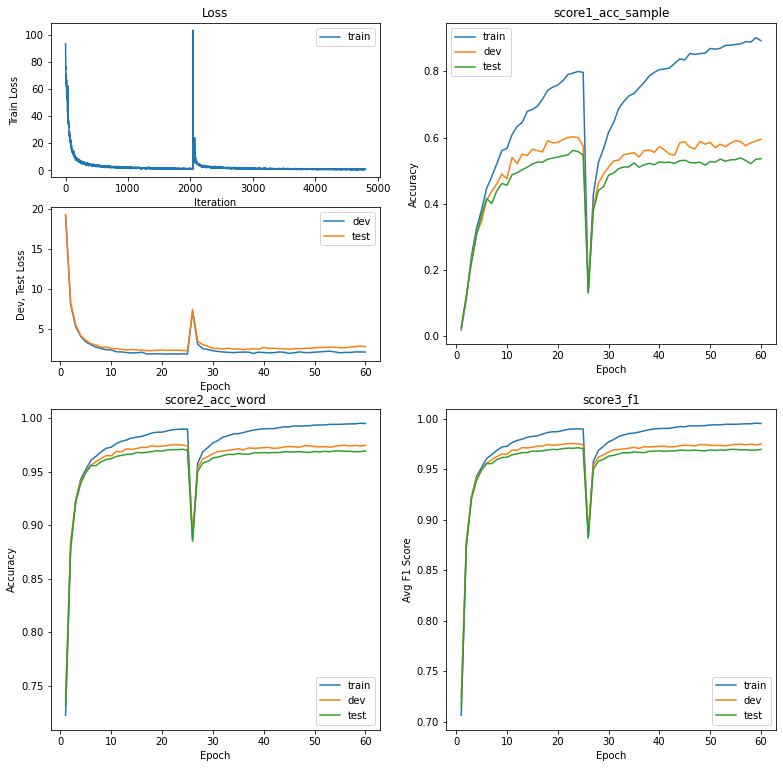

In [14]:
showGraph(dict_losses, dict_scores)

In [15]:
score_type=2
for i in range(len(dict_scores["train"][score_type])):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')

0.70665   0.7244   0.71497
0.8733   0.8796   0.87447
0.92235   0.9221   0.91986
0.94272   0.9411   0.93875
0.95169   0.9492   0.94897
0.96041   0.956   0.95539
0.96422   0.9591   0.95544
0.96849   0.9623   0.95936
0.97183   0.965   0.96144
0.97262   0.9645   0.96178
0.97614   0.9689   0.96409
0.97838   0.9684   0.96517
0.97958   0.9713   0.9662
0.98148   0.9709   0.96632
0.9823   0.9716   0.96778
0.98298   0.9727   0.96768
0.98457   0.9727   0.96805
0.9862   0.9743   0.96883
0.98693   0.9735   0.96953
0.98698   0.974   0.96921
0.98814   0.9744   0.9703
0.98929   0.9752   0.97074
0.98958   0.9752   0.97058
0.98982   0.9749   0.97112
0.98973   0.9742   0.97009
0.88267   0.8883   0.88177
0.95752   0.9534   0.94991
0.96842   0.9618   0.95786
0.97256   0.9641   0.95968
0.97686   0.9667   0.9628
0.97918   0.9689   0.96355
0.98228   0.9693   0.96505
0.98374   0.9701   0.96627
0.98518   0.9707   0.96594
0.98553   0.9715   0.96703
0.98664   0.9704   0.96654
0.98786   0.9722   0.96621
0.98893   

In [16]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 300
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
    calc(model, input_seq, target_seq)
    break
#     print(target_seq)

words               tags    targets
Public              JJ      JJ
protests            NNS     NNS
against             IN      IN
him                 PRP     PRP
were                VBD     VBD
triggered           VBN     VBN
in                  IN      IN
June                NNP     NNP
1987                CD      CD
due                 JJ      JJ
to                  TO      TO
charges             NNS     NNS
by                  IN      IN
Diaz                NNP     NNP
Herrera             NNP     NNP
,                   ,       ,
his                 PRP$    PRP$
former              JJ      JJ
chief               NN      NN
of                  IN      IN
staff               NN      NN
,                   ,       ,
that                IN      IN
Mr.                 NNP     NNP
Noriega             NNP     NNP
had                 VBD     VBD
stolen              VBN     VBN
the                 DT      DT
1984                CD      CD
election            NN      NN
and                 CC

In [17]:
sen = 'I am your father .'
# in_sen = torch.tensor(engdict.indexesFromSentence(sen), device=device)

# sen2 = [4609,   25,   35,  116, 4610, 1562,   74,  115, 4611,   49, 4612, 1456,
#         4613,  224,  691,    6, 4614,   76,   30, 1742, 4615,  308,  107, 4614,
#          116, 4616, 4617,   17]
# in_sen = torch.tensor(sen2, device=device)

calc(model, sen)

words               tags
I                   PRP
am                  VBP
your                PRP$
father              NN
.                   .


In [18]:
best_model = torch.load('best_char_bilstm_crf_pos.pt')
s_dev = scores(best_model, datasets['dev'], 100)
s_test = scores(best_model, datasets['test'], 100)
print(s_dev)
print(s_test)

(0.6004273504273504, 0.975255391600454, 0.9752067923545837)
(0.5482107355864811, 0.9707030837748275, 0.9707372188568115)
